In [1]:
from util import info
import numpy as np
import os
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [78]:
#021923 -- example for ARVO, ERM
#081122 -- example for visionarium?
#100522B -- only 4 stimulus positions?
#071323B regions 1 and 2


bin_dir = r"C:\Users\zfj\data\021923B\func"
# bin_dir = r"C:\Users\zfj\data\081023B\func"
# bin_dir = r"C:\Users\zfj\data\082423B\func"
# bin_dir = r"C:\Users\zfj\data\082523B\func"

# froot = r"region2_927nm_00002"

froot = "p1141_p1632_linear"

data = np.load(os.path.join(bin_dir,f'{froot}_spots_interp.npy'))
labels = np.load(os.path.join(bin_dir,f'{froot}_spots_loc.npy'))
xn = np.load(os.path.join(bin_dir,f'{froot}_spots_ti.npy'))
data = np.moveaxis(data,1,2) # trials -by- time -by- cells
data.shape

(3920, 50, 101)

In [4]:
import imageio as iio
plt.figure(figsize=(7,7))
# plt.subplot(1,3,1)

img = iio.imread(os.path.join(bin_dir,'..','p1141_p1632_stack_red.tif'))

proj = np.clip(img.max(axis=0),35000, 50000)
plt.imshow(proj, cmap=LinearSegmentedColormap.from_list('red', [(0,0,0), (1,0,0)]))
mask = np.asarray(iio.imread(os.path.join(bin_dir,'..','p1141_p1632_stack_red_42_masks.png'))).reshape((512,512))

# use_rois = [24, 109 ,62, 222]
use_rois = [5, 62, 130, 198]
txt = ['A', 'B', 'C', 'D']

qx,qy = np.meshgrid(np.arange(512),np.arange(512))
# for roi in range(1, mask.max()):
for i,roi in enumerate(use_rois):
    x = np.median(qx[mask==roi])
    y = np.median(qy[mask==roi]) 
    if x > -1 and x < 512 and y>-1 and y <512:
        plt.text(x,y + 5,txt[i], ha='center', va='center', color='w', fontsize=20, fontweight='bold')
        # plt.text(x,y + 5,roi, ha='center', va='center', color='w', fontsize=20, fontweight='bold')
        # pass


# res = 210.6 / 512  # microns per pixel
res = 512 / 210.6 # pixels per micron

plt.plot(np.array([0, 60 * res, 60* res, 0, 0]) + 256-30*res, np.array([0, 0, 60* res, 60*res, 0]) + 256-30*res , c='w', linewidth=3)

plt.plot([50,50 + res*50], [480,480], c='w', linewidth=3)
plt.axis('off')
t = plt.text(0,0,'tdTomato', ha='left', va='top', color='red')#
t.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='none'))
#, backgroundcolor='k', alpha=0.5)

# plt.subplot(1,3,2)
# plt.subplot(1,3,3)


plt.savefig(r"C:\Users\zfj\Downloads\Fig7A0.svg", transparent=True)

C:\Users\zfj\AppData\Local\Temp\ipykernel_20764\2418974160.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(os.path.join(bin_dir,'..','p1141_p1632_stack_red.tif'))


FileNotFoundError: No such file: 'C:\Users\zfj\data\082423B\p1141_p1632_stack_red.tif'

<Figure size 700x700 with 0 Axes>

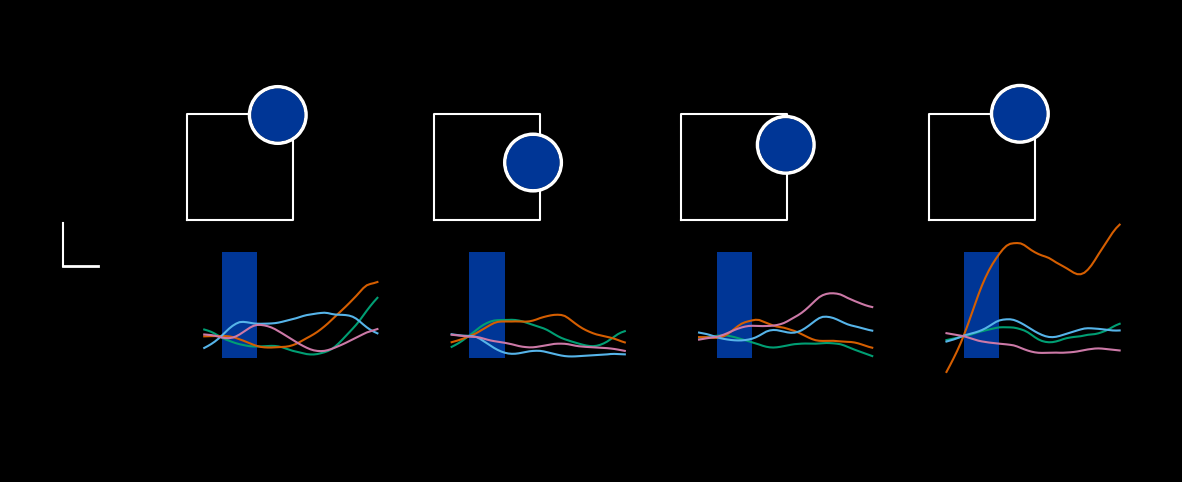

In [343]:
ti = np.load(r"C:\Users\zfj\data\021923B\func\spots_ti.npy")
from matplotlib.collections import EllipseCollection

stimc = '#0052e2aa' # this is the one from the palette, but seems wrong?

plt.figure(figsize=(15,6))
ns = 4
r = [6, 28, 42, 54]
t = 128 #54 okay...

green, red, blue, magenta = [0, 158, 115], [213, 94, 0], [86, 180, 233], [204, 121, 167]
colors = [[c[0]/255, c[1]/255, c[2]/255, 1] for c in (green, red, blue, magenta)]


scale = 12
xs = 70

for s in range(ns):
    x = np.array([5 + xs*s, 15 + xs*s])
    # x = np.array([10 + 70*s, 20 + 70*s])
    
    # x = np.array([5 + 50*s, 15 + 50*s])

    plt.fill_between(x, -.5*scale, 2*scale, edgecolor='none', facecolor=stimc)

    x,y = np.array([-30, 30, 30, -30, -30]), np.array([-30, -30, 30, 30, -30])

    sto = 4
    plt.plot(x/2 + s * xs + 10, y/2 + scale * sto, c='w')

    x,y = labels[t+s,0], labels[t+s,1]
    x,y = x / 2 + s*xs + 10, y/2 + scale * sto
    ec = EllipseCollection(17,17,0,units='xy',facecolor='w', offsets=(x,y), offset_transform=plt.gca().transData, zorder=8)
    plt.gca().add_collection(ec)   
    ec = EllipseCollection(15,15,0,units='xy',facecolor='k', offsets=(x,y), offset_transform=plt.gca().transData, zorder=9)
    plt.gca().add_collection(ec)
    ec = EllipseCollection(15,15,0,units='xy',facecolor=stimc, offsets=(x,y), offset_transform=plt.gca().transData, zorder=10)
    plt.gca().add_collection(ec)



for c in range(4):
    plt.plot(scale*np.concatenate((data[t:(t+ns) ,:, r[c]], np.empty((4,20))*np.nan), axis=1).flatten(), c=colors[c])
    # dc = data[t:(t+ns),:,r[c]].copy()

    # for i in range(1,ns):
    #     s = dc[i-1,-1] - dc[i-1,-2]
    #     o = s + dc[i-1,-1] - dc[i,0]
    #     # print(o)
    #     dc[i,:] += o
    # plt.plot(scale * dc.flatten(), c=colors[c])

    
tres = 50 / 1.25 # units per second

sbo = 20

plt.plot([-40, -40 + tres*.25], [sbo, sbo], c='w', linewidth=2) #.25 seconds
plt.plot([-40, -40], [sbo, sbo+scale],c='w') # df/f = 1
plt.axis('equal')

plt.axis('off')
plt.ylim(-.5 * scale, 5 * scale)


plt.savefig(r"C:\Users\zfj\Downloads\Fig7A1.svg", transparent=True)

In [344]:
chirps,ti = np.load(os.path.join(bin_dir,'chirps_interp.npy')), np.load(os.path.join(bin_dir,'chirps_ti.npy'))
chirps.shape, data.shape
# ti.min(), ti.max()



((55, 101, 500), (3920, 50, 101))

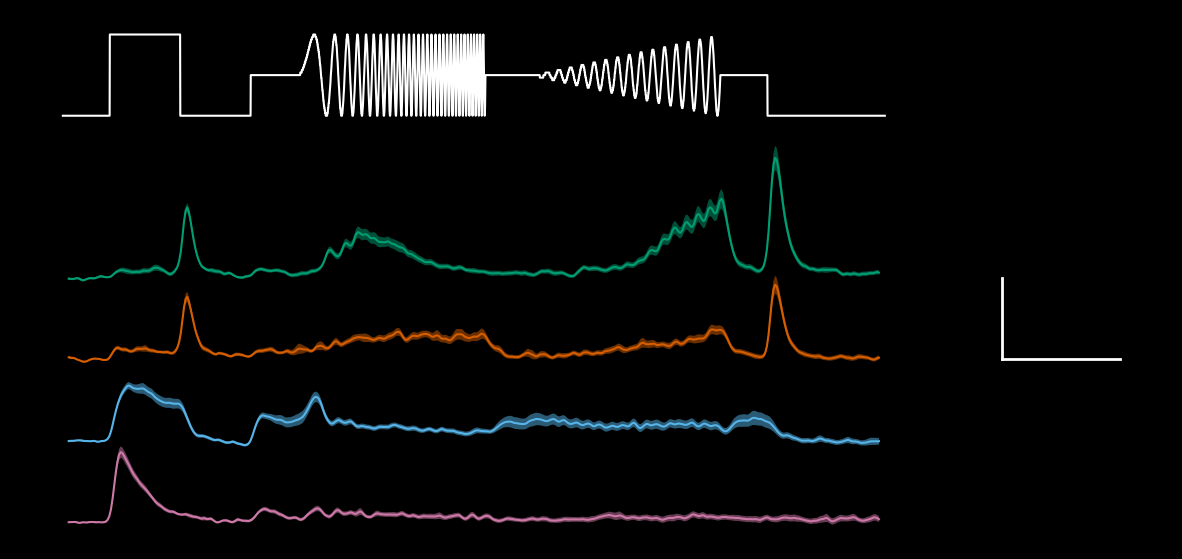

In [348]:
plt.figure(figsize=(15,7))

scale = .5

for i,ri in enumerate(reversed(r)):
    # rsp = np.median(chirps[:,ri,:],axis=0)
    bl = chirps[:,ri,ti<0].mean(axis=-1, keepdims=True) 
    ch = (chirps[:,ri,:] - bl)/ bl
    # ch /= ch
    rsp = np.mean(ch,axis=0) * scale
    # rsp /= rsp.max()
    # rsp

    rsp_s = np.std(ch,axis=0)/ np.sqrt(len(ch)) * scale

    plt.fill_between(ti, rsp +  i - rsp_s, rsp + i + rsp_s, facecolor=colors[3 - i], edgecolor='none', alpha=.5)
    plt.plot(ti, rsp + i, c=colors[3 - i])



def chirp_pattern(intensity, sf = 60):
   sf = int(sf)
   chirp = np.concatenate((
        np.zeros(2*sf), #pre time
        np.ones(3*sf), #positive step
        np.zeros(3*sf), #negative time
        np.ones(2*sf) * 0.5, #inter time
        
        -np.sin(2*np.pi*np.linspace(0,8/sf,sf*8).cumsum() + np.pi)/2 + .5, # freq chirp

        np.ones(2*sf) * 0.5, #inter time
        -np.linspace(0,1,sf*8)*np.sin(2*np.pi*2*np.arange(1/sf, 8+(1/sf), 1/sf) + np.pi)/2 + .5, # amp chirp
      

        np.ones(2*sf) * 0.5, #inter time
        np.zeros(5*sf), #tail time
   )) 

   return np.round(chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)

cp = chirp_pattern(.125,sf = 120)
tic = np.linspace(-2, 33, len(cp))
plt.plot(tic, cp / cp.max() + 5, c='w')

plt.plot([38,43], [2,2], c='w', linewidth=2) #t = 5sec
plt.plot([38,38], [2,3], c='w', linewidth=2) #df/f = 0.5

plt.axis('off')

plt.savefig(r"C:\Users\zfj\Downloads\Fig7A2.svg", transparent=True)

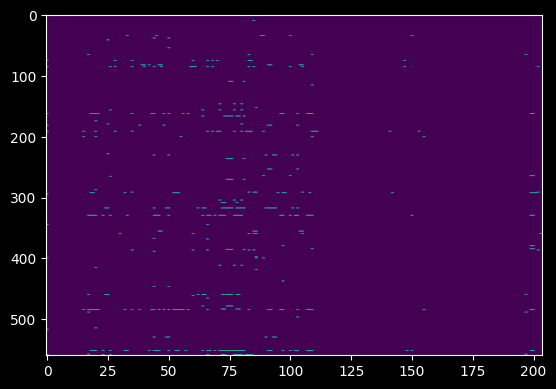

In [18]:
plt.imshow(np.all(np.isnan(data[:, xn<0]),axis=1), aspect=1/4)

In [79]:
#drop bad cells
# data = data[:,:,np.mean(np.any(np.isnan(data), axis=1), axis=0) < .2]

#fill missing
data[np.isnan(data)] = 0.


ncells = data.shape[-1]

print(data.shape, labels.shape)
#filter epochs
# data = data[500:]
# labels = labels[500:]

(3920, 50, 101) (3920, 2)


In [419]:
# xn = np.linspace(-.25,1.0,200)
# xn = xn[7:-10]

# data = np.load(r"C:\Users\zfj\data\081122B\func\spots_smooth.npy")
# data = np.moveaxis(data[:,:,7:-10],0,2)
# # fdata = data.reshape(data.shape[0],-1)

# labels = np.load(r"C:\Users\zfj\data\081122B\func\spots_labels.npy")
# ue = np.array([
# [-24.74181249, -24.74181249, -16.49454166, -16.49454166, -16.49454166,
#    -8.24727083,  -8.24727083,   0.,           0.,           0.,
#     8.24727083,   8.24727083,  16.49454166,  16.49454166,  16.49454166,
#    24.74181249,  24.74181249],
# [-14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
#   -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
#   -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
#   -14.2846921,   14.2846921 ]]).T

# ##################################
# data = np.concatenate((
#     np.load(r"C:\Users\zfj\data\100522B\region1_00001\spots_smooth.npy").T,
#     np.load(r"C:\Users\zfj\data\100522B\region1_00002\spots_smooth.npy").T,
# ), axis=1)
# data = np.moveaxis(data[7:-5,:,:],0,1)
# data = np.concatenate((
#     data[:136],
#     data[137:]
# ), axis=0)

# labels = np.concatenate((
#     np.load(r"C:\Users\zfj\data\100522B\region1_00001\spots_labels.npy"),
#     np.load(r"C:\Users\zfj\data\100522B\region1_00002\spots_labels.npy"),
# ), axis=0)
# labels = np.concatenate((
#     labels[:136],
#     labels[137:]
# ), axis=0)


# print(data.shape, labels.shape, np.unique(labels), ue.shape, ue[labels,:].shape, xn.shape)

# cv = KFold(5, shuffle=True, random_state=0)
# train, test = list(cv.split(data, labels))[0]

# xtrain, xtest = data[train], data[test]
# ytrain, ytest = ue[labels[train,None]], ue[labels[test,None]]

In [5]:
cv = KFold(5, shuffle=True, random_state=0)
train, test = list(cv.split(data, labels))[0]

xtrain, xtest = data[train], data[test]
ytrain, ytest = labels[train,None,:], labels[test,None,:]

In [56]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape
# trials -by- time -by- cells


((448, 50, 198), (448, 1, 2), (112, 50, 198), (112, 1, 2))

In [6]:
# tmri = layers.Input((None,ncells))
# ffns = []
# cnv1 = tmri
# for _ in range(2):
#     for i in range(6):
#         cnv1 = layers.SeparableConv1D(32, 2, dilation_rate=2**i, padding='causal')(cnv1)
#         cnv1 = layers.LayerNormalization()(cnv1)
#         cnv1 = layers.Activation('relu')(cnv1)
#         cnv1 = layers.SeparableConv1D(ncells, 2, dilation_rate=2**i, padding='causal')(cnv1)
#         cnv1 = layers.LayerNormalization()(cnv1)
#         cnv1 = layers.Add()([cnv1, tmri])
#         ffns.append(cnv1)
#     cnv1 = layers.Add()([*ffns, tmri])
# ffnt = layers.Activation('sigmoid')(cnv1)
# ffnt = layers.Dense(2)(ffnt)


# mod = keras.Model(inputs=tmri, outputs = ffnt)
# mod.summary()

xtrain = xtrain.reshape((xtrain.shape[0],-1))
ytrain = ytrain.reshape((ytrain.shape[0],2))
xtest = xtest.reshape((xtest.shape[0],-1))
ytest = ytest.reshape((ytest.shape[0],2))


tmi = layers.Input(xtrain.shape[-1])
# cnv = layers.Concatenate()([layers.Conv1D(1, int(i), padding='causal', activation='relu')(tmi) for i in np.linspace(8.0, 64.0, 16)])
tmii = layers.LayerNormalization()(tmi)
tmii = layers.Dense(512)(tmii)

ffn = layers.Dense(512, activation='relu')(tmi)
ffn = layers.Add()([tmii, ffn])
ffn = layers.LayerNormalization()(ffn)
for i in range(6):
    ffn = layers.Dense(512, activation='relu')(ffn)
    ffn = layers.Add()([tmii, ffn])
    ffn = layers.LayerNormalization()(ffn)
# ffn = layers.Dense(512, activation='relu')(ffn)
# ffn = layers.Add()([tmii, ffn])
ffn = layers.Dense(2)(ffn)
mod = keras.Model(inputs=tmi, outputs = ffn)
mod.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5050)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5050)        10100       ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 512)          2586112     ['layer_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 512)          2586112     ['input_1[0][0]']            

In [7]:
mod.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
)
history = mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=25, verbose=1))



Epoch 1/200
98/98 [==============================] - 4s 29ms/step - loss: 194.9218 - val_loss: 174.2361
Epoch 2/200
98/98 [==============================] - 3s 26ms/step - loss: 107.0400 - val_loss: 188.0455
Epoch 3/200
98/98 [==============================] - 7s 72ms/step - loss: 78.2968 - val_loss: 185.6370
Epoch 4/200
98/98 [==============================] - 7s 76ms/step - loss: 58.7616 - val_loss: 189.8780
Epoch 5/200
98/98 [==============================] - 6s 65ms/step - loss: 46.0165 - val_loss: 193.3574
Epoch 6/200
98/98 [==============================] - 7s 76ms/step - loss: 34.7791 - val_loss: 209.3832
Epoch 7/200
98/98 [==============================] - 7s 76ms/step - loss: 26.4756 - val_loss: 202.4673
Epoch 8/200
98/98 [==============================] - 7s 71ms/step - loss: 22.9949 - val_loss: 208.1780
Epoch 9/200
98/98 [==============================] - 8s 77ms/step - loss: 19.0757 - val_loss: 200.9708
Epoch 10/200
98/98 [==============================] - 7s 75ms/step - lo

KeyboardInterrupt: 

In [8]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: name 'history' is not defined

In [9]:
# np.sqrt(158), 2**5
ptest = mod.predict(xtest)

# ptest[:,-1,:]

In [11]:
ptest = ptest.reshape((ptest.shape[0],-1,ptest.shape[-1]))
ytest = ytest.reshape((ytest.shape[0],-1,ytest.shape[-1]))

# ptest
# plt.plot(ptest[0,:,0])
# plt.axhline(ytest[0,0,0], 0, 50)
ptest.shape, ytest.shape

err = np.sqrt(np.sum((ptest[:,-1,:] - ytest[:,0,:])**2, axis=1))

# edir = np.arctan2(ptest[:,-1,1] - ytest[:,0,1], ptest[:,-1,0] - ytest[:,0,0])
edir = np.arctan2(ytest[:,-1,1] - ptest[:,-1,1], ytest[:,-1,0] - ptest[:,-1,0])

In [11]:
#randomly permute the ptest
# calculate the average error
err_b = np.empty(1000)
for k in range(1000):
    err_b[k]= np.sqrt(np.sum((np.random.permutation(ptest)[:,-1,:] - ytest[:,0,:])**2, axis=1)).mean()


(21.40821962419774, 20.283448912215075)

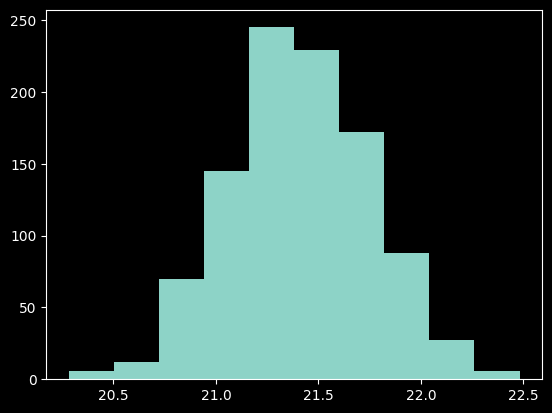

In [12]:
plt.hist(err_b)
np.mean(err_b),np.percentile(err_b,.05)

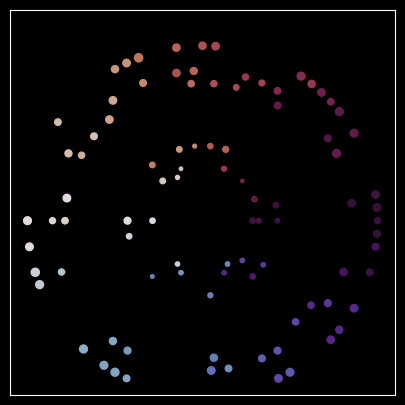

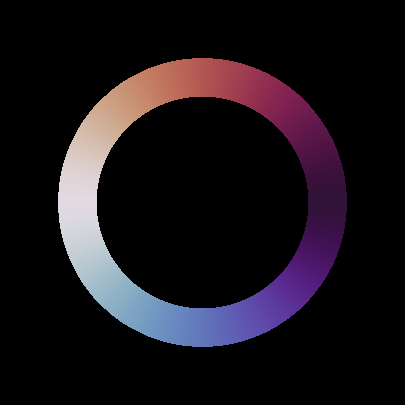

21.070985179194196


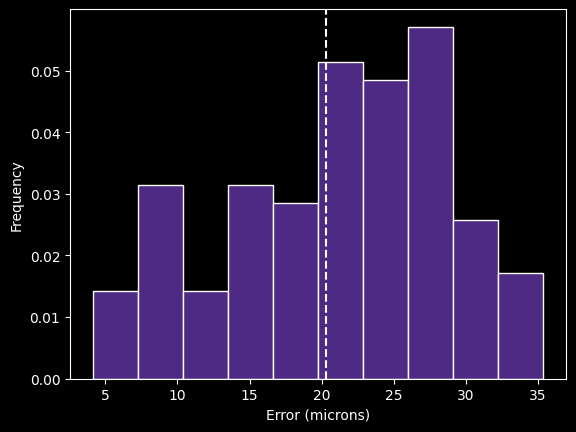

In [13]:
# _,axs = plt.subplots(1,2,figsize=(12,5))
fig = plt.figure(figsize=(6,5))

# ax = plt.subplot(121)
sc = plt.scatter(ytest[:,0,0], ytest[:,0,1], err, c=edir/np.pi*180, cmap='twilight')
plt.axis('square')
plt.xticks([])
plt.yticks([])


# fig.colorbar(sc, ax=ax)

plt.figure(figsize=(6,5))
# ax = plt.gca()
ax = plt.subplot( projection='polar')

import matplotlib as mpl
from matplotlib import cm

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(-np.pi, np.pi) 

# Plot a color mesh on the polar plot
# with the color set by the angle

n = 2000  #the number of secants for the mesh
t = np.linspace(-np.pi,np.pi,n)   #theta values
r = np.linspace(.6,.7,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap='twilight')  #plot the colormesh on axis with colormap

ax.axis('off')
ax.set_ylim(0,1)



# # plt.colorbar()
plt.show()
plt.hist(err, density=True, color='#4E2A84',edgecolor='w')

# plt.axvline(np.percentile(err_b,.05),0,1,color='w',zorder=-1)
plt.axvline(np.percentile(err_b,.05),0,1,color='w',linestyle='--')
plt.xlabel('Error (microns)')
plt.ylabel('Frequency')


print(err.mean())

In [15]:
from seaborn import kdeplot

# plt.figure().add_subplot(projection='polar')
# sc = plt.scatter(edir, err, cmap='twilight')

cbar=False

for i in range(1,4):
    th = np.linspace(0,2*np.pi,100)
    plt.plot(10*i*np.cos(th), 10*i*np.sin(th), 'w', alpha=.5)
    plt.text(i*10+1, 0, f"{i*10}", fontsize=8)
plt.text(i*10+1, 0, f"{i*10}" + u'\u03bc' + 'm', fontsize=8)

kdeplot(x=err*np.cos(edir), y=err*np.sin(edir), fill=True, cmap='inferno', cbar=cbar)


# th = np.linspace(0,2*np.pi,5) + np.pi/4
# plt.plot(60*np.cos(th), 60*np.sin(th), 'w')


plt.axis('square')
plt.axis('off')

# plt.colorbar()



ModuleNotFoundError: No module named 'seaborn'

C:\Users\zfj\AppData\Local\Temp\ipykernel_23692\288656443.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno')
C:\Users\zfj\AppData\Local\Temp\ipykernel_23692\288656443.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=.001)
C:\Users\zfj\AppData\Local\Temp\ipykernel_23692\288656443.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{abs(i):0.0f}" for i in np.linspace(-35,0,8)])


(-37.064106107937285,
 36.67953255636291,
 -37.257933902740476,
 36.48570476155972)

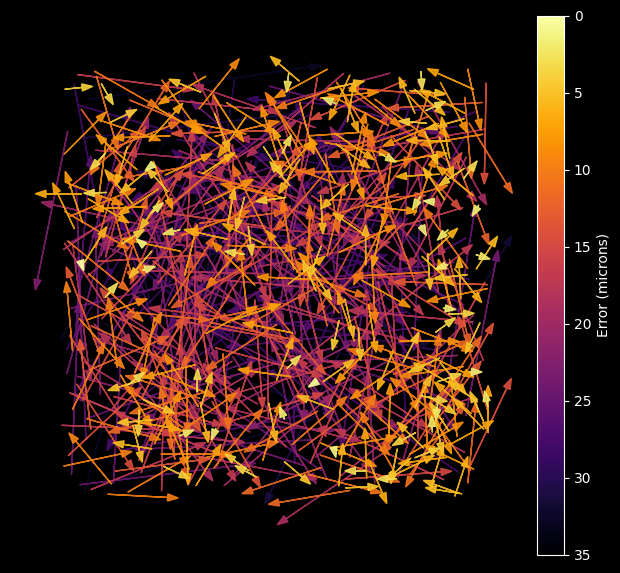

In [12]:
import matplotlib

cmap = matplotlib.cm.get_cmap('inferno')
norm = matplotlib.colors.Normalize(vmin=-35.0, vmax=0.0)

plt.figure(figsize=(8,7))

ii = np.flip(np.argsort(err))

for k in range(len(ytest)):
    i = ii[k]
    # plt.quiver(ytest[:,0,0], ytest[:,0,1], 300*(ptest[:,0,0] - ytest[:,0,0]), 300*(ptest[:,0,1] - ytest[:,0,1]), angles='xy')
    plt.arrow(ytest[i,0,0], ytest[i,0,1], ptest[i,0,0] - ytest[i,0,0], ptest[i,0,1] - ytest[i,0,1], color=cmap(norm(-err[i])), length_includes_head=True, head_width=1, alpha=.9)
# ytest.squeeze().shape, ptest.shape
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


cbar = plt.colorbar(sm, pad=.001)
cbar.set_label('Error (microns)')
cbar.ax.set_yticklabels([f"{abs(i):0.0f}" for i in np.linspace(-35,0,8)])

plt.axis('square')
plt.axis('off')
# plt.scatter(ytest[:,0,0], ytest[:,0,1])

In [100]:
## Null distribution

# # ptest
# # plt.plot(ptest[0,:,0])
# # plt.axhline(ytest[0,0,0], 0, 50)
# ptest.shape, ytest.shape

# # err = np.sqrt(np.sum((ptest[:,-1,:] - ytest[:,0,:])**2, axis=1))
# err = np.sqrt(np.sum((ptest[:,0,:] - ytest[:,0,:])**2, axis=1))

# # edir = np.arctan2(ptest[:,-1,1] - ytest[:,0,1], ptest[:,-1,0] - ytest[:,0,0])
# # edir = np.arctan2(ytest[:,-1,1] - ptest[:,-1,1], ytest[:,-1,0] - ptest[:,-1,0])
# edir = np.arctan2(ytest[:,0,1] - ptest[:,0,1], ytest[:,0,0] - ptest[:,0,0])

# # _,axs = plt.subplots(1,2,figsize=(12,5))
# fig = plt.figure(figsize=(12,5))

# ax = plt.subplot(121)
# sc = plt.scatter(ytest[:,0,0], ytest[:,0,1], err, c=edir/np.pi*180, cmap='twilight')


# # fig.colorbar(sc, ax=ax)

# ax = plt.subplot(122, projection='polar')

# import matplotlib as mpl
# from matplotlib import cm

# # Define colormap normalization for 0 to 2*pi
# norm = mpl.colors.Normalize(-np.pi, np.pi) 

# # Plot a color mesh on the polar plot
# # with the color set by the angle

# n = 200  #the number of secants for the mesh
# t = np.linspace(-np.pi,np.pi,n)   #theta values
# r = np.linspace(.6,1,2)        #radius values change 0.6 to 0 for full circle
# rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
# c = tg                         #define color values as theta value
# im = ax.pcolormesh(t, r, c.T,norm=norm, cmap='twilight')  #plot the colormesh on axis with colormap

# ax.set_yticklabels([])                   #turn of radial tick labels (yticks)
# ax.tick_params(pad=15,labelsize=24)      #cosmetic changes to tick labels
# ax.spines['polar'].set_visible(False)    #turn off the axis spine.
# ax.axis('off')


# # # plt.colorbar()
# plt.show()
# plt.hist(err, density=True)
# plt.xlabel('Error (microns)')
# plt.ylabel('Frequency')



In [17]:
ptest.shape, ytest.shape

((684, 1, 2), (684, 1, 2))

In [33]:
# for k in bootstrap:

# pick a,b

# project pred_b - pred_a onto b - a

# count if positive
# 

d = np.empty((1000,1000))
b = np.empty((1000,1000), dtype=bool)


for j in range(1000):
    for k in range(1000):
        i = np.random.choice(len(ytest), 2, replace=False)
        # print(ytest[i])
        
        d[k,j] = np.sqrt(np.sum((ytest[i[0],-1] - ytest[i[1],-1])**2))
        b[k,j] = np.dot((ytest[i[0],-1] - ytest[i[1],-1]), (ptest[i[0],-1] - ptest[i[1],-1])) > 0




KeyboardInterrupt: 

C:\Users\zfj\AppData\Local\Temp\ipykernel_26828\3017898144.py:8: RuntimeWarning: Mean of empty slice.
  plt.hist(np.array([bj[jj].mean() for bj,jj in zip(b,j)]))
c:\Users\zfj\anaconda3\envs\func_img\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


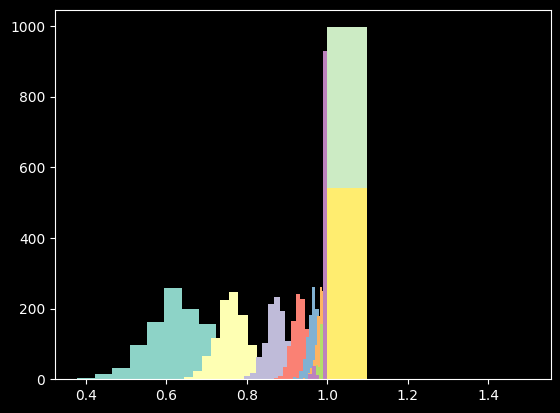

In [19]:
for i in range(10):
    j = (d > d.max()/10*i) & (d <= d.max()/10*(i+1))

    # j = (d[0] > d[0].max()/10*i) & (d[0] <= d[0].max()/10*(i+1))
    # j.shape, b.shape

    # print([len(b[jj]) for jj in j])
    plt.hist(np.array([bj[jj].mean() for bj,jj in zip(b,j)]))

# j.shape, b.shape
# j.shape

# b[j[1:]].shape

11.938659739658561


C:\Users\zfj\AppData\Local\Temp\ipykernel_26828\1406059344.py:23: RuntimeWarning: Mean of empty slice.
  di[i] = np.array([dj[jj].mean() for dj,jj in zip(d,j)]).mean()
C:\Users\zfj\AppData\Local\Temp\ipykernel_26828\1406059344.py:24: RuntimeWarning: Mean of empty slice.
  bi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).mean()
C:\Users\zfj\AppData\Local\Temp\ipykernel_26828\1406059344.py:25: RuntimeWarning: Mean of empty slice.
  bsi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).std()


Text(0, 0.5, 'Discrimination accuracy')

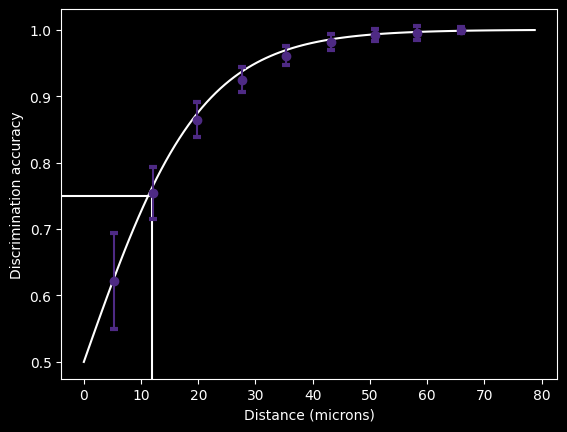

In [20]:
def logifunc(x,k):
    return 1. / (1 + np.exp(-k*x))

from scipy.optimize import curve_fit

popt, pcov = curve_fit(logifunc, d[0], b[0])
# print(popt, pcov)
ei = np.linspace(0, d[0].max(), 100)
e = logifunc(ei, popt)


# plt.scatter(d,b)
di = np.zeros(10)
bsi = np.zeros(10)
bi = np.zeros(10)
# ni = np.zeros(10)

for i in range(10):
    # j = (d[0] > d[0].max()/10*i) & (d[0] <= d[0].max()/10*(i+1))
    j = (d > d[0].max()/10*i) & (d <= d[0].max()/10*(i+1))
    
    # di[i] = np.array([d[jj].mean() for jj in j]).mean()
    di[i] = np.array([dj[jj].mean() for dj,jj in zip(d,j)]).mean()
    bi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).mean()
    bsi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).std()
    

    # di[i] = d[0][j[0]].mean()

    # # bsi[i] = b[0][j].std()
    
    # bi[i] = b[0][j[0]].mean()
    # ni[i] = np.count_nonzero(j)


plt.errorbar(di,bi,bsi, linestyle='none', marker='o', capsize=3, capthick=3)

plt.plot(ei,e)
xl = plt.xlim()
yl = plt.ylim()
plt.cla()

plt.vlines(ei[np.argwhere(e>=.75)[0,0]],yl[0],.75,color='w')
plt.hlines(.75, xl[0], ei[np.argwhere(e>=.75)[0,0]])        

# plt.scatter(d,b)

plt.plot(ei, e, 'w')
# plt.scatter(di,bi, color="#4E2A84", zorder=3)
plt.errorbar(di,bi,bsi, linestyle='none', marker='o', color="#4E2A84", capsize=3, capthick=3)
# plt.boxplot()



plt.xlim(xl)
plt.ylim(yl)

print(ei[np.argwhere(e>=.75)[0,0]])

plt.xlabel('Distance (microns)')
plt.ylabel('Discrimination accuracy')

In [13]:
def get_thresh(y,p, do_plotting = False):
    from scipy.optimize import curve_fit
    def logifunc(x,k):
        return 1. / (1 + np.exp(-k*x))


    N = len(y)

    i = np.triu_indices(N, 1)
    vyx = (y[:,None,0] - y[None,:,0])[i]
    vpx = (p[:,None,0] - p[None,:,0])[i]    
    vyy = (y[:,None,1] - y[None,:,1])[i]
    vpy = (p[:,None,1] - p[None,:,1])[i]

    d = np.sqrt(vyx**2 + vyy**2)
    b = ((vyx * vpx) + (vyy * vpy)) > 0

    k, _ = curve_fit(logifunc, d, b, p0=0.027)

    if do_plotting:
        di, ji = np.unique(np.round(d*100)/100, return_inverse=True)
        ndists = len(di)

        bsi = np.zeros(ndists)
        bi = np.zeros(ndists)

        for i in range(1,ndists):
            bi[i] = np.nanmean(b[ji==i])
            bsi[i] = np.nanstd(b[ji==i])/np.sqrt(np.count_nonzero(ji==i))

        di[0] = 0
        bi[0] = .5

        plt.errorbar(di,bi,bsi, linestyle='none', marker='o', capsize=3, capthick=3)
        
        ei = np.linspace(0, d.max(), 100)
        e = logifunc(ei, k.mean()) 
        plt.plot(ei,e)

        xl = plt.xlim()
        yl = plt.ylim()
        plt.cla()

        th = np.log(1/3)/-k.mean()
        plt.vlines(th,yl[0],.75,color='w')
        plt.hlines(.75, xl[0], th)        

        plt.plot(ei, e, 'w')
        # plt.errorbar(di,bi,bsi, linestyle='none', marker='o', color="#4E2A84", capsize=3, capthick=3)
        plt.errorbar(di,bi,bsi, linestyle='none', marker='o', color="w", capsize=3, capthick=3)


        plt.xlim(xl)
        plt.ylim(yl)
        # print(th)

        plt.xlabel('Distance (microns)')
        plt.ylabel('Discrimination accuracy')


    return np.log(1/3)/-k

In [36]:
ytest.shape, ptest.shape

((112, 1, 2), (112, 1, 2))

array([19.6710111])

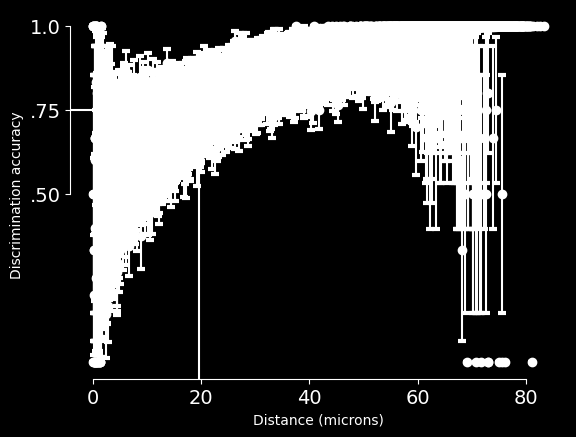

In [14]:
th = get_thresh(ytest[:,0], ptest[:,0], do_plotting=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines[['top','right']].set_color('none')
plt.gca().spines['left'].set_bounds([0.5,1.0])
plt.gca().spines['bottom'].set_bounds([0,80])

plt.yticks([0.5, 0.75, 1.0], labels=['.50', '.75', '1.0'])

th

In [16]:
# plt.scatter(ytest[:,0,0], ytest[:,0,1])

ystest = (ytest[:,None,:]//5 + .5)*5
# plt.scatter(ystest[:,0,0], ystest[:,0,1])
# ystest = ytest.copy()


In [18]:
ystest.shape, ptest.shape

((784, 1, 1, 2), (784, 1, 2))

[19.80076554]


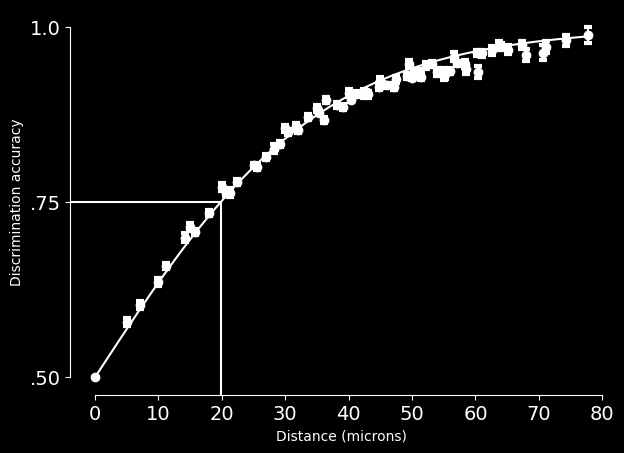

In [19]:
plt.figure(figsize=(7,5))

th = get_thresh(ystest[:,0,0], ptest[:,0], do_plotting=True)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines[['top','right']].set_color('none')
plt.gca().spines['left'].set_bounds([0.5,1.0])
plt.gca().spines['bottom'].set_bounds([0,80])

plt.yticks([0.5, 0.75, 1.0], labels=['.50', '.75', '1.0'])
print(th)


# plt.savefig(r"C:\Users\zfj\Downloads\Fig7B1.svg", transparent=True)
plt.savefig(r"C:\Users\zfj\Downloads\linear_interp.png", transparent=True)

In [91]:
labels_s = (labels//5 + .5)*5
u, ui = np.unique(labels_s, axis=0, return_inverse=True)

# xtrain, xtest = data[train], data[test]
# ytrain, ytest = labels[train,None,:], labels[test,None,:]
data.shape, labels.shape, u.shape

In [87]:

data = np.load(os.path.join(bin_dir,f'{froot}_chirps_interp.npy'))
# labels = np.load(os.path.join(bin_dir,f'{froot}_chirps_loc.npy'))
xn = np.load(os.path.join(bin_dir,f'{froot}_chirps_ti.npy'))
data = np.moveaxis(data,1,2) # trials -by- time -by- cells

data[np.isnan(data)]=0
data.shape

(55, 500, 101)

In [93]:
QI.shape

(144, 101)

(array([41., 37., 15.,  1.,  3.,  2.,  0.,  0.,  1.,  1.]),
 array([0.07879919, 0.14675796, 0.21471673, 0.2826755 , 0.35063427,
        0.41859304, 0.48655181, 0.55451058, 0.62246935, 0.69042812,
        0.75838689]),
 <BarContainer object of 10 artists>)

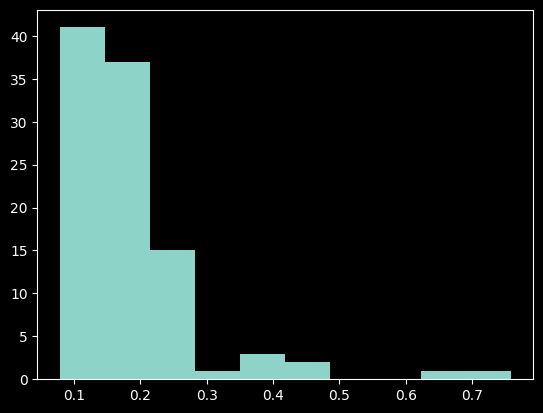

In [96]:
# xtest.shape, ui.shape
# xtest[ui==0].shape
# data[ui==0].shape
# plt.imshow(data[ui==0].mean(axis=0))
# plt.colorbar()

# QI = np.asarray([data[ui==i].mean(axis=0).var(axis=0) / data[ui==0].var(axis=0).mean(axis=0) for i in range(len(u))])


QI = data[:10].mean(axis=0).var(axis=0) / data[:5].var(axis=0).mean(axis=0)

# plt.imshow(QI, interpolation='none', aspect=1/2)
# plt.colorbar()
# plt.clim(0, 1.0)
# plt.hist(SNR)

plt.hist(QI.flatten())



In [98]:
# QIt = np.linspace(.01, 1, 50)
ROC = np.array([(QI > th).sum(axis=-1) for th in np.linspace(0.1, 1, 50)])
# ROC = np.array([(QI > th).sum(axis=1) for th in np.linspace(0.1, 1, 50)])
# QI.shape
ROC.shape

(50,)

Text(0, 0.5, 'Number of Cells')

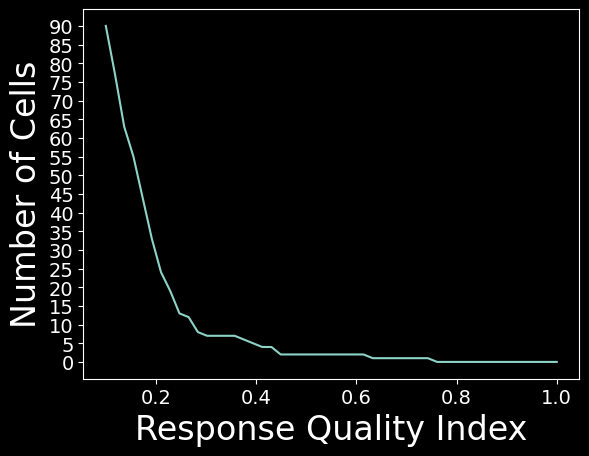

In [103]:
# plt.imshow(ROC.T)
# plt.colorbar()
plt.plot(np.linspace(0.1, 1, 50), ROC)
# plt.plot(np.linspace(0.1, 1, 50), ROC.mean(axis=-1), c='w', linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,95,5),fontsize=14)

plt.xlabel('Response Quality Index', fontsize=24)
plt.ylabel('Number of Cells', fontsize=24)


# plt.savefig(r"C:\Users\zfj\Downloads\linear_interp_QI.png", transparent=True)

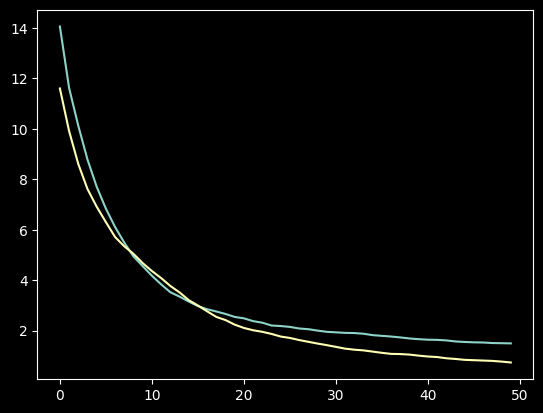

In [86]:
# old= ROC
ROC.shape
plt.plot(ROC.mean(axis=1))
plt.plot(old.mean(axis=1))


array([25.61858146])

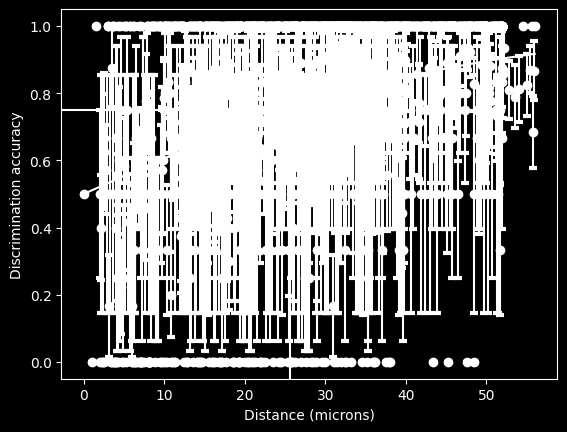

In [43]:
stest = xtest.copy().reshape((-1,*data.shape[1:]))
u, ltest = np.unique(ystest, axis=0, return_inverse = True)
u = u[:,0,:].T

for c in range(data.shape[-1]):
    for i in range(ltest.max()):
        stest[ltest == i, :, c] = np.random.permutation(stest[ltest == i, :, c])

pstest = mod.predict(stest.reshape(xtest.shape))

th = get_thresh(ystest[:,0], pstest, do_plotting=True)

th

In [67]:
u.shape

(143, 2)

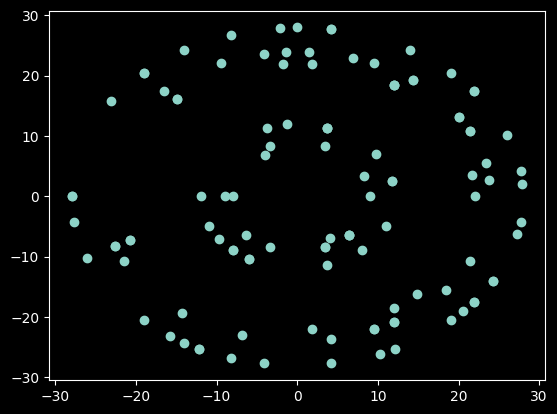

In [48]:
# ystest.shape, ptest.shape, pstest.shape
plt.scatter(ystest[:,0,0], ystest[:,0,1])

In [44]:
# plt.figure(figsize=(25,25))

tmin  = []
tsmin = []

udist = np.sqrt(((u.T[:,None,:] - u.T[None,:,:])**2).sum(axis=-1))
th_map = np.zeros(u.shape[1])
th_s_map = np.zeros(u.shape[1])

for kk in np.linspace(6,80, 100):
    for i,c in enumerate(u.T):
        j = np.argwhere(udist[i] < kk)
        
        k = np.isin(ltest, j)
        # print(np.count_nonzero(k))

        t = (c + 105) / 210
        # plt.axes([*t, .1, .1])

        th_map[i] = get_thresh(ystest[k,0], ptest[k,0], do_plotting=False)
        th_s_map[i] = get_thresh(ystest[k,0], pstest[k], do_plotting=False)
        
    th_map[th_map < 0] = np.infty
    th_s_map[th_s_map < 0] = np.infty

    tmin.append(th_map.min())
    tsmin.append(th_s_map.min())


ValueError: `ydata` must not be empty!

(11.555555555555555, 7.3369699831923025, 6.904516222400649)

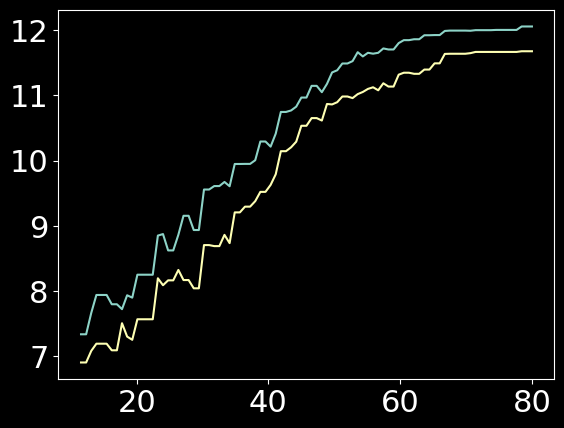

In [ ]:
k=11
plt.plot(np.linspace(3,80, 100)[k:], tmin[k:])
plt.plot(np.linspace(3,80, 100)[k:], tsmin[k:])
np.linspace(3,80, 100)[k], tmin[k], tsmin[k]


In [415]:
udist[0,1:].min()

16.49454165883888

In [49]:
udist = np.sqrt(((u.T[:,None,:] - u.T[None,:,:])**2).sum(axis=-1))
th_map = np.zeros(u.shape[1])
th_s_map = np.zeros(u.shape[1])

for i,c in enumerate(u.T):
    j = np.argwhere(udist[i] < 30)
    
    k = np.isin(ltest, j)
    # print(np.count_nonzero(k))

    t = (c + 105) / 210
    # plt.axes([*t, .1, .1])

    th_map[i] = get_thresh(ystest[k,0], ptest[k,0], do_plotting=False)
    th_s_map[i] = get_thresh(ystest[k,0], pstest[k], do_plotting=False)
    
th_map[th_map < 0] = np.infty
th_s_map[th_s_map < 0] = np.infty


In [50]:
th_map.min(), th_map[~np.isinf(th_map)].max(), th_s_map.min(), th_s_map[~np.isinf(th_s_map)].max()

(14.85614887141184, 43.643218302713066, 16.306391667894893, 41.62071501148249)

14.85614887141184 43.643218302713066


C:\Users\zfj\AppData\Local\Temp\ipykernel_20764\739407103.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('inferno')


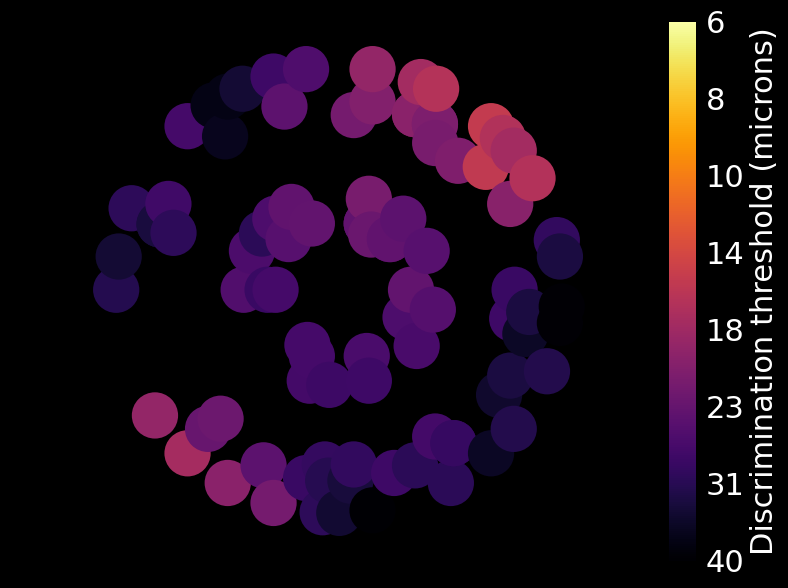

In [51]:
# patches = [plt.Circle((cxy[0],-cxy[1]),(u.max()-u.min())/np.sqrt(u.shape[1])/2) for cxy in u.T]
# coll = matplotlib.collections.PatchCollection(patches, cmap=LinearSegmentedColormap.from_list(cmaps[c], [(0,0,0), colors[c][:-1]]))

import matplotlib
import matplotlib as mpl

# # coll.set_array(np.abs(v[:,0]))
# coll.set_array(sml_comp[c])
# plt.gca().add_collection(coll)

mpl.rcParams.update({'font.size': 22})


clim = [np.log10(6), np.log10(40)]

cmap = mpl.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=-clim[1], vmax=-clim[0])

plt.figure(figsize=(10,7))
# plt.scatter(*u, s=600, c = cmap(norm(-np.log10(th_map))))
patches = [plt.Circle((cxy[0],-cxy[1]),(u.max()-u.min())/np.sqrt(u.shape[1])/2) for cxy in u.T]

coll = matplotlib.collections.PatchCollection(patches, cmap=cmap)

coll.set_array(-np.log10(th_map))
plt.gca().add_collection(coll)



# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sm = coll
coll.set_clim(-clim[1], -clim[0])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, pad=.001)

cbar.set_label('Discrimination threshold (microns)')
cbar.ax.set_yticks(np.linspace(-clim[1],-clim[0],8))
cbar.ax.set_yticklabels([f"{10**abs(i):0.0f}" for i in np.linspace(-clim[1],-clim[0],8)])

cbar.ax.tick_params(color='none')#, direction='in', pad=-10)#, horizontalalignment='left')
cbar.outline.set_edgecolor('none')

plt.xlabel('Horziontal position (microns)')
plt.ylabel('Vertical position (microns)')

# plt.axis('square')
plt.axis('equal')
plt.axis('off')

print(th_map.min(), th_map[~np.isinf(th_map)].max())

# nosie corr: 9.418774481733289 2561.0183912263437
# no noise corr: 12.348962823119741 254.42476311805797


# plt.savefig(r"C:\Users\zfj\Downloads\Fig7B2.svg")

In [366]:
#Wassle 2009

print(
    np.sqrt(3 * 1e6 / 12867 / (np.sqrt(3/4)*3)), # cone spacing
    np.sqrt(3 * 1e6 / 5001 / (np.sqrt(3/4)*3)), # t5bp spacing
    
    np.sqrt(3 * 1e6 / 3379 / (np.sqrt(3/4)*3)), # t6bp spacing
    np.sqrt(3 * 1e6 / 616 / (np.sqrt(3/4)*3)), # t9bp spacing
    
)




9.47318532788269 15.195194269573268 18.485899526928506 43.29565637572987


[0.47712125 0.69897    1.         1.69897   ]


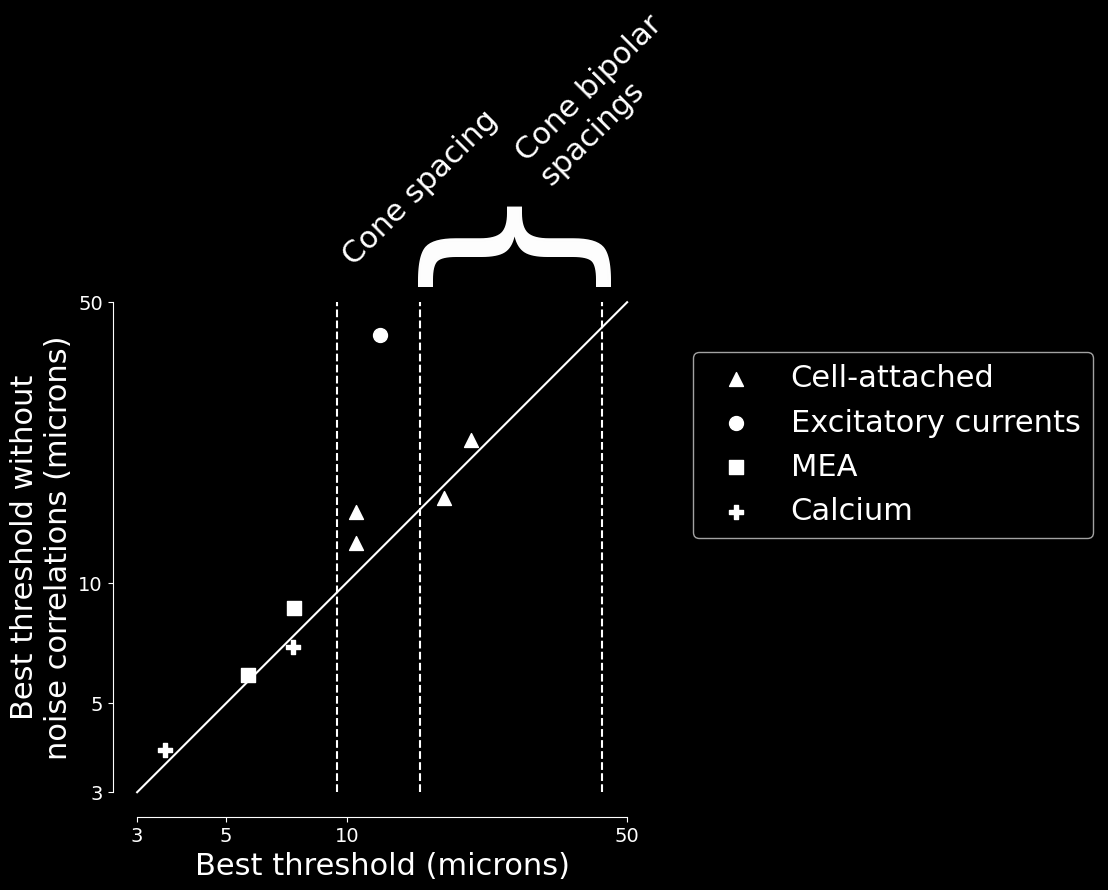

In [530]:
#assembling data here from all modalities, for lack of a better place....
markers = ['^', 'o', 's', 'P']
# method = ['Cell-attached', 'Calcium', 'MEA', 'EPSC']
method = ['Cell-attached', 'Excitatory currents', 'MEA', 'Calcium']
th_min = [[10.56,17.44,10.56,20.39],12.13,[5.67,7.4],[7.34,3.53]]
th_s_min = [[12.57,16.28,14.95,22.64],41.38,[5.89,8.62],[6.9,3.82],]


# 12.13203429656669, 41.37878519726417

fig = plt.figure(figsize=(15,7))

for m,x,y,t in zip(markers, th_min, th_s_min, method):
    s = plt.scatter(np.log10(x),np.log10(y),s=100,c='w',marker=m)
    s.set_label(t)

xl = np.log10(4),np.log10(50)

b = [np.log10(3),np.log10(50)]

plt.plot(b, b, c='w')

plt.ylim(xl[0], xl[1] + 12)
plt.xlim(xl)

plt.axis('square')

# plt.yscale('log')
# plt.xscale('log')

xt = np.array([3,5, 10, 50])
plt.xticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=14)
plt.yticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=14)


# plt.xticklabels()

# plt.yticks(fontsize=14)

plt.xlabel('Best threshold (microns)')
plt.ylabel('Best threshold without\nnoise correlations (microns)')


plt.gca().spines[['top','right']].set_color('none')
plt.gca().spines['left'].set_bounds(b)
plt.gca().spines['bottom'].set_bounds(b)

fig.legend(loc='center right')

print(np.log10(xt))
plt.vlines(np.log10(9.47), np.log10(3), np.log10(50), color='w', linestyles="--")
plt.vlines(np.log10(15.195), np.log10(3), np.log10(50), color='w', linestyles="--")
plt.vlines(np.log10(43.3), np.log10(3), np.log10(50), color='w', linestyles="--")

# 15.195194269573268 18.485899526928506 43.29565637572987

plt.text(np.log10(9.47), np.log10(60), 'Cone spacing', rotation=45, ha = 'left', va = 'bottom')
plt.text((np.log10(15.195) + np.log10(43.3))/2, np.log10(95), 'Cone bipolar\nspacings', rotation=45, ha = 'left', va = 'bottom')

plt.annotate(r"}",fontsize=150,rotation=90, fontweight='ultralight', ha='center', va='bottom',
            xy=((np.log10(15.195) + np.log10(43.3))/2 - np.log10(1.1), np.log10(55)), color='w')


plt.savefig(r"C:\Users\zfj\Downloads\Fig8.svg", transparent=True)

# plt.axis('off')

[0.47712125 1.         1.47712125 2.38021124]


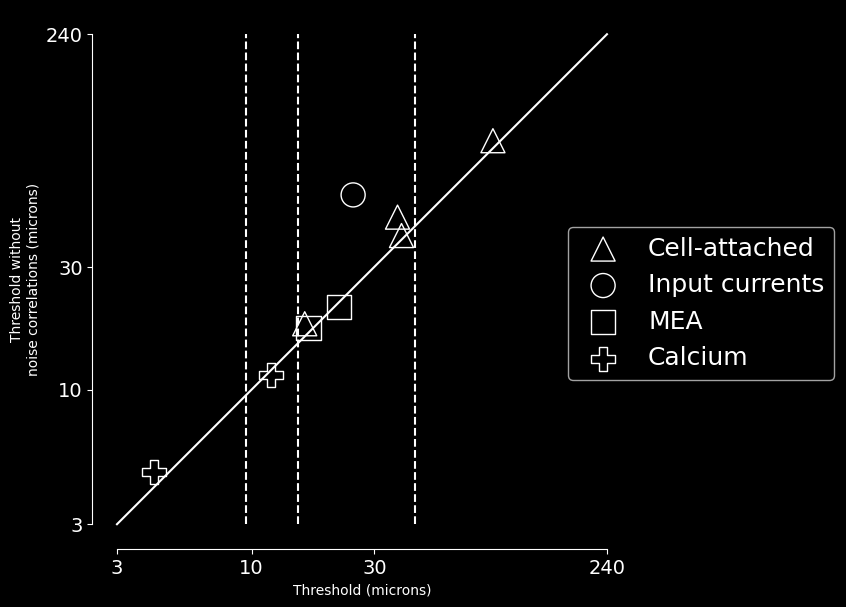

In [46]:
#assembling data here from all modalities, for lack of a better place....
markers = ['^', 'o', 's', 'P']
# method = ['Cell-attached', 'Calcium', 'MEA', 'EPSC']
method = ['Cell-attached', 'Input currents', 'MEA', 'Calcium']
th_min = [[16.08, 86.55, 36.87, 38.21],24.79,[16.63, 21.79],[11.89, 4.19]]
th_s_min = [[18.02, 92.61, 46.76, 39.66],57.03,[17.3, 20.93],[11.38, 4.8],]


fig = plt.figure(figsize=(10,7))

for m,x,y,t in zip(markers, th_min, th_s_min, method):
    s = plt.scatter(np.log10(x),np.log10(y),s=300,facecolor='none',edgecolor='w',marker=m)
    s.set_label(t)

xl = np.log10(4),np.log10(240)

b = [np.log10(3),np.log10(240)]

plt.plot(b, b, c='w')

plt.ylim(xl)
plt.xlim(xl)

plt.axis('square')

# plt.yscale('log')
# plt.xscale('log')

xt = np.array([3, 10, 30, 240])
plt.xticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=14)
plt.yticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=14)


# plt.xticklabels()

# plt.yticks(fontsize=14)

plt.xlabel('Threshold (microns)')
plt.ylabel('Threshold without\nnoise correlations (microns)')


plt.gca().spines[['top','right']].set_color('none')
plt.gca().spines['left'].set_bounds(b)
plt.gca().spines['bottom'].set_bounds(b)

fig.legend(loc='center right', fontsize=18)

print(np.log10(xt))
plt.vlines(np.log10(9.47), np.log10(3), np.log10(240), color='w', linestyles="--")
plt.vlines(np.log10(15.195), np.log10(3), np.log10(240), color='w', linestyles="--")
plt.vlines(np.log10(43.3), np.log10(3), np.log10(240), color='w', linestyles="--")

# 15.195194269573268 18.485899526928506 43.29565637572987

# plt.savefig(r"C:\Users\zfj\Downloads\Fig8.svg", transparent=True)

# plt.axis('off')

[0.47712125 1.         1.47712125 1.77815125]


(-3.0, 7.0)

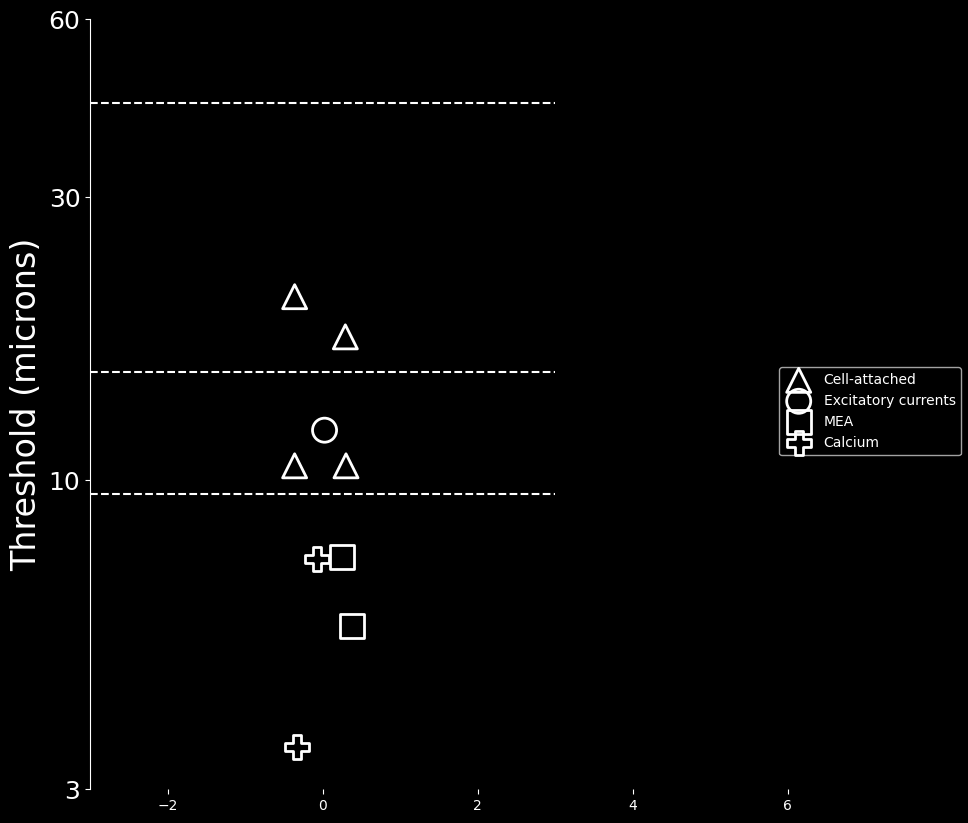

In [57]:
#assembling data here from all modalities, for lack of a better place....
markers = ['^', 'o', 's', 'P']
# method = ['Cell-attached', 'Calcium', 'MEA', 'EPSC']
method = ['Cell-attached', 'Excitatory currents', 'MEA', 'Calcium']
# th_min = [[16.08, 86.55, 36.87, 38.21],[24.79],[16.63, 21.79],[11.89, 4.19]]

th_min = [[10.56,17.44,10.56,20.39],[12.13],[5.67,7.4],[7.34,3.53]]
th_s_min = [[18.02, 92.61, 46.76, 39.66],[57.03],[17.3, 20.93],[11.38, 4.8],]


fig = plt.figure(figsize=(10,10))

for m,x,y,t in zip(markers, th_min, th_s_min, method):

    s = plt.scatter(.3*np.random.randn(len(x)),np.log10(x),s=300,facecolor='none',edgecolor='w',marker=m, linewidths=2)
    s.set_label(t)

xl = np.log10(4),np.log10(60)

b = [np.log10(3),np.log10(60)]

# plt.plot(b, b, c='w')

plt.ylim(xl)
# plt.xlim(xl)

# plt.axis('square')

# plt.yscale('log')
# plt.xscale('log')

xt = np.array([3, 10, 30, 60])
# plt.xticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=14)
plt.yticks(np.log10(xt),labels=[str(x) for x in xt],fontsize=18)


# plt.xticklabels()

# plt.yticks(fontsize=14)

# plt.xlabel('Threshold (microns)')
plt.ylabel('Threshold (microns)', fontsize=24)


plt.gca().spines[['top','right','bottom']].set_color('none')
plt.gca().spines['left'].set_bounds(b)
# plt.gca().spines['bottom'].set_bounds(b)

fig.legend(loc='center right')

print(np.log10(xt))
# plt.hlines(np.log10(9.47), np.log10(3), np.log10(240), color='w', linestyles="--")
# plt.hlines(np.log10(15.195), np.log10(3), np.log10(240), color='w', linestyles="--")
# plt.hlines(np.log10(43.3), np.log10(3), np.log10(240), color='w', linestyles="--")
plt.hlines(np.log10(9.47), -3, 3, color='w', linestyles="--")
plt.hlines(np.log10(15.195),-3, 3, color='w', linestyles="--")
plt.hlines(np.log10(43.3), -3, 3, color='w', linestyles="--")



plt.xlim([-3,7])
# 15.195194269573268 18.485899526928506 43.29565637572987

# plt.savefig(r"C:\Users\zfj\Downloads\Fig8.svg", transparent=True)

# plt.axis('off')

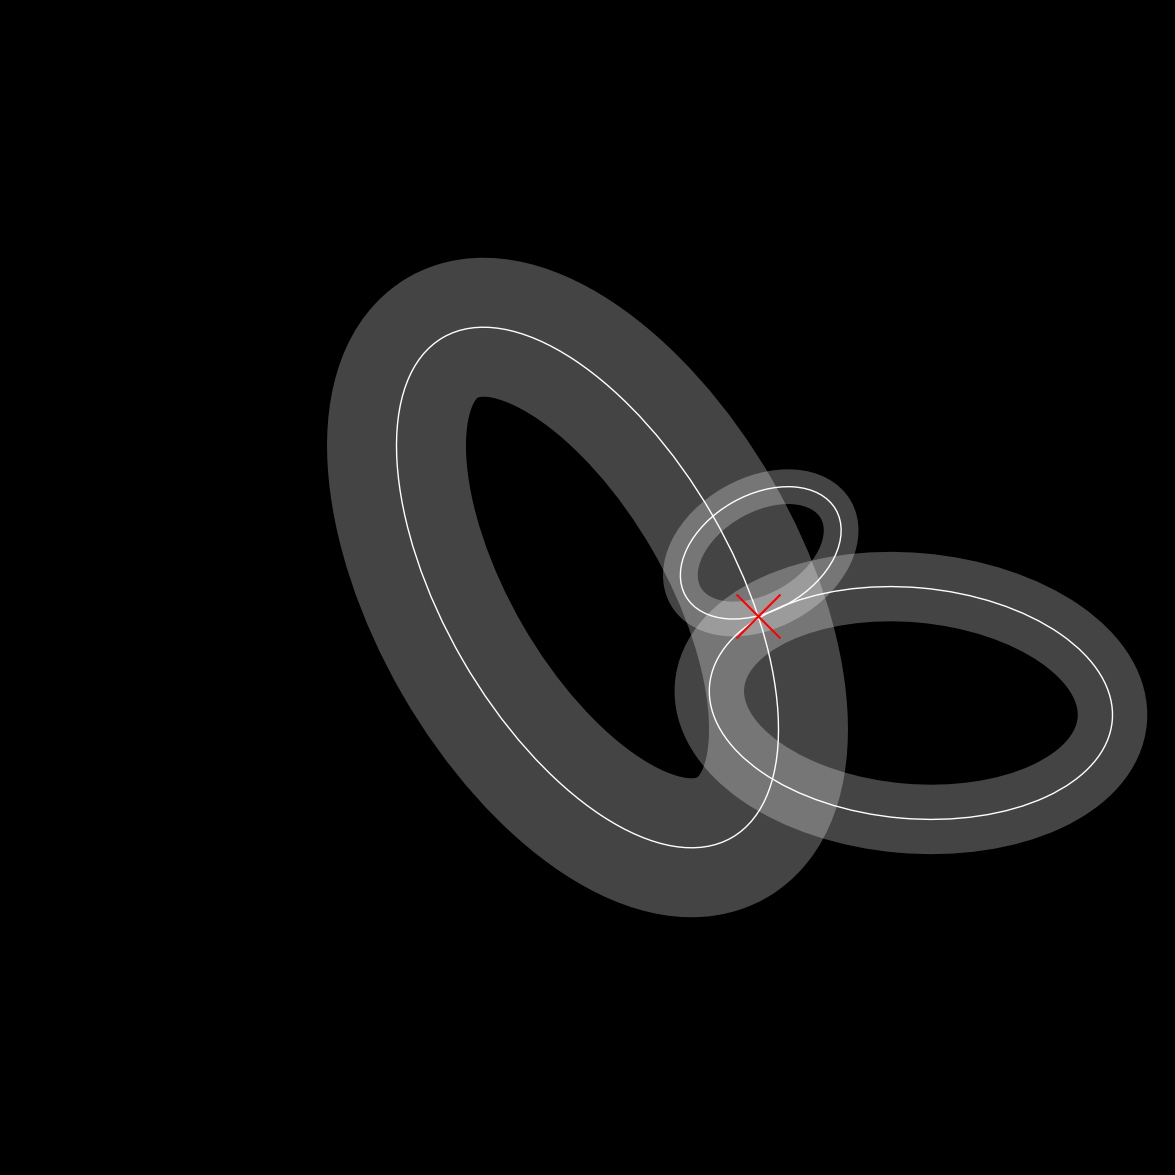

In [358]:
## Figure 1

from matplotlib.collections import EllipseCollection


plt.figure(figsize=(15,15))
ax = plt.gca()
plt.xlim(-100,100)
plt.ylim(-100,100)

plt.axis('square')

lw = 25
a = .27

sc = EllipseCollection(offsets = (0,0), widths = 50, heights = 100, angles=30, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=4*lw, alpha=a)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)

sc = EllipseCollection(offsets = (30,6), widths = 30, heights = 20, angles=30, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=lw, alpha=a)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)

sc = EllipseCollection(offsets = (56,-20), widths = 70, heights = 40, angles=175, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=2*lw, alpha=a)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)



sc = EllipseCollection(offsets = (0,0), widths = 50, heights = 100, angles=30, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=1, alpha=1)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)

sc = EllipseCollection(offsets = (30,6), widths = 30, heights = 20, angles=30, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=1, alpha=1)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)

sc = EllipseCollection(offsets = (56,-20), widths = 70, heights = 40, angles=175, units='xy', offset_transform=ax.transData, facecolors='none', edgecolors='w', linewidth=1, alpha=1)#, facecolors='None', edgecolors=sig)
ax.add_collection(sc)






plt.scatter(29.5,-5,s=1000,c='r',marker='x')

plt.axis('off')


plt.savefig(r"C:\Users\zfj\Downloads\Fig1.svg")

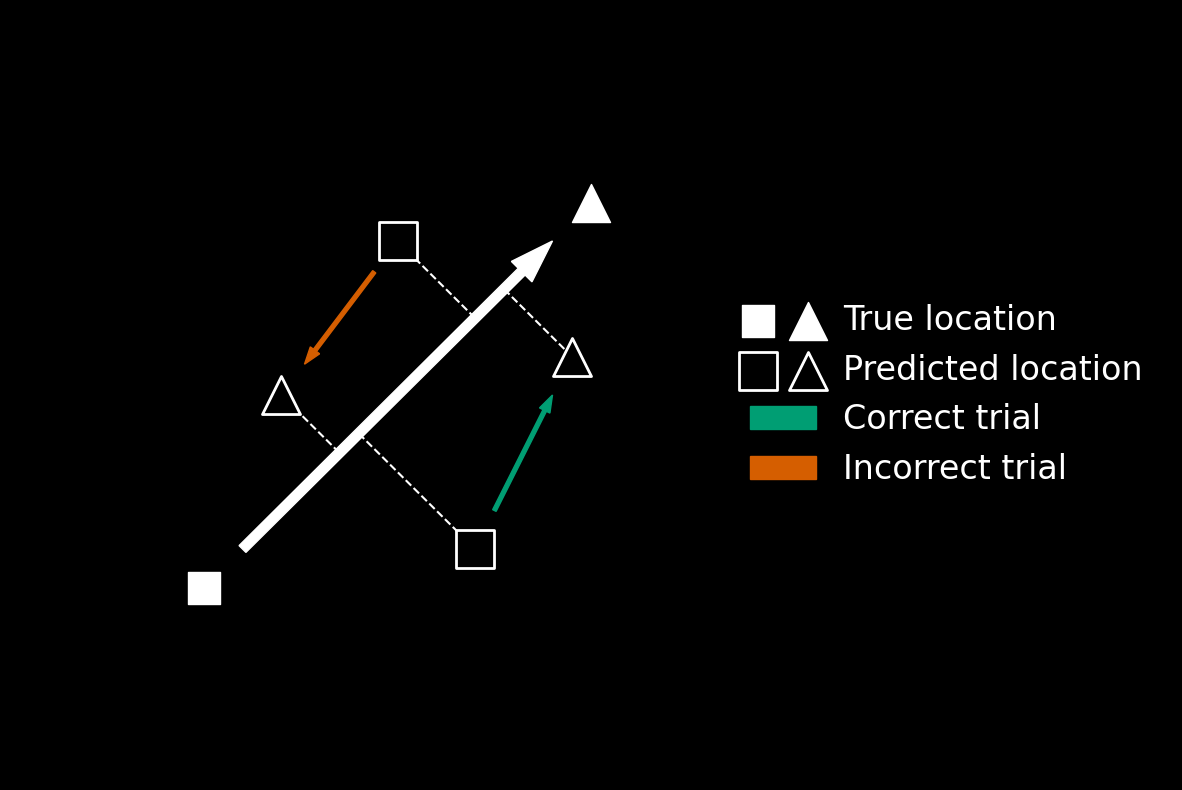

In [191]:
## Figure 3B
from matplotlib.legend_handler import HandlerTuple

green, red, blue, magenta = [0, 158, 115], [213, 94, 0], [86, 180, 233], [204, 121, 167]
colors = [[c[0]/255, c[1]/255, c[2]/255, 1] for c in (green, red, blue, magenta)]

plt.figure(figsize=(15,10))

s0 = plt.scatter(0, 0, s=500, c='w', marker='s')
s1 = plt.scatter(1, 1, s=750, c='w', marker='^')

# plt.scatter(.5, .9, s=750, marker='^', facecolor='none', edgecolor='w', linewidth=2)
# plt.scatter(.2, .5, s=750, marker='s', facecolor='none', edgecolor='w', linewidth=2)




plt.arrow(0.1, 0.1, .8, .8, width=.025, color='w', length_includes_head=True, label = 'True displacement')

(ax,ay), (bx,by) = (.7,.1), (.95,.6)

f = .8
a0 = plt.arrow(ax*f + bx*(1-f) , ay*f + by*(1-f), bx*(1-2*(1-f)) - ax*(1-2*(1-f)), by*(1-2*(1-f)) - ay*(1-2*(1-f)), width=.01, color=colors[0], length_includes_head=True)


plt.plot([(ax + ay)/2, ax], [(ax + ay)/2, ay], c='w', linestyle = '--')
plt.plot([(bx + by)/2, bx], [(bx + by)/2, by], c='w', linestyle = '--')

p0 = plt.scatter(ax, ay, s=750, marker='s', facecolor='k', edgecolor='w', linewidth=2, zorder=100)
p1 = plt.scatter(bx, by, s=750, marker='^', facecolor='k', edgecolor='w', linewidth=2, zorder=100)



(ax,ay), (bx,by) = (.5,.9), (.2,.5)
a1 = plt.arrow(ax*f + bx*(1-f) , ay*f + by*(1-f), bx*(1-2*(1-f)) - ax*(1-2*(1-f)), by*(1-2*(1-f)) - ay*(1-2*(1-f)), width=.01, color=colors[1], length_includes_head=True)


plt.plot([(ax + ay)/2, ax], [(ax + ay)/2, ay], c='w', linestyle = '--')
plt.plot([(bx + by)/2, bx], [(bx + by)/2, by], c='w', linestyle = '--')

plt.scatter(ax, ay, s=750, marker='s', facecolor='k', edgecolor='w', linewidth=2, zorder=100, label='Predicted location')
plt.scatter(bx, by, s=750, marker='^', facecolor='k', edgecolor='w', linewidth=2, zorder=100)


plt.xlim(-.5, 2.5)
plt.ylim(-.5, 1.5)
plt.axis('off')

leg = plt.legend([(s0,s1), (p0,p1), a0, a1], ['True location', 'Predicted location', 'Correct trial', 'Incorrect trial'],loc='center right', handler_map={tuple: HandlerTuple(ndivide=None,pad=1)}, fontsize=24, frameon=False)

# for line in leg.get_lines():
#     line.set_linewidth(0.05)

plt.savefig(r"C:\Users\zfj\Downloads\Fig3B.svg", transparent=True)

Text(0.2, 0.5, 'A')

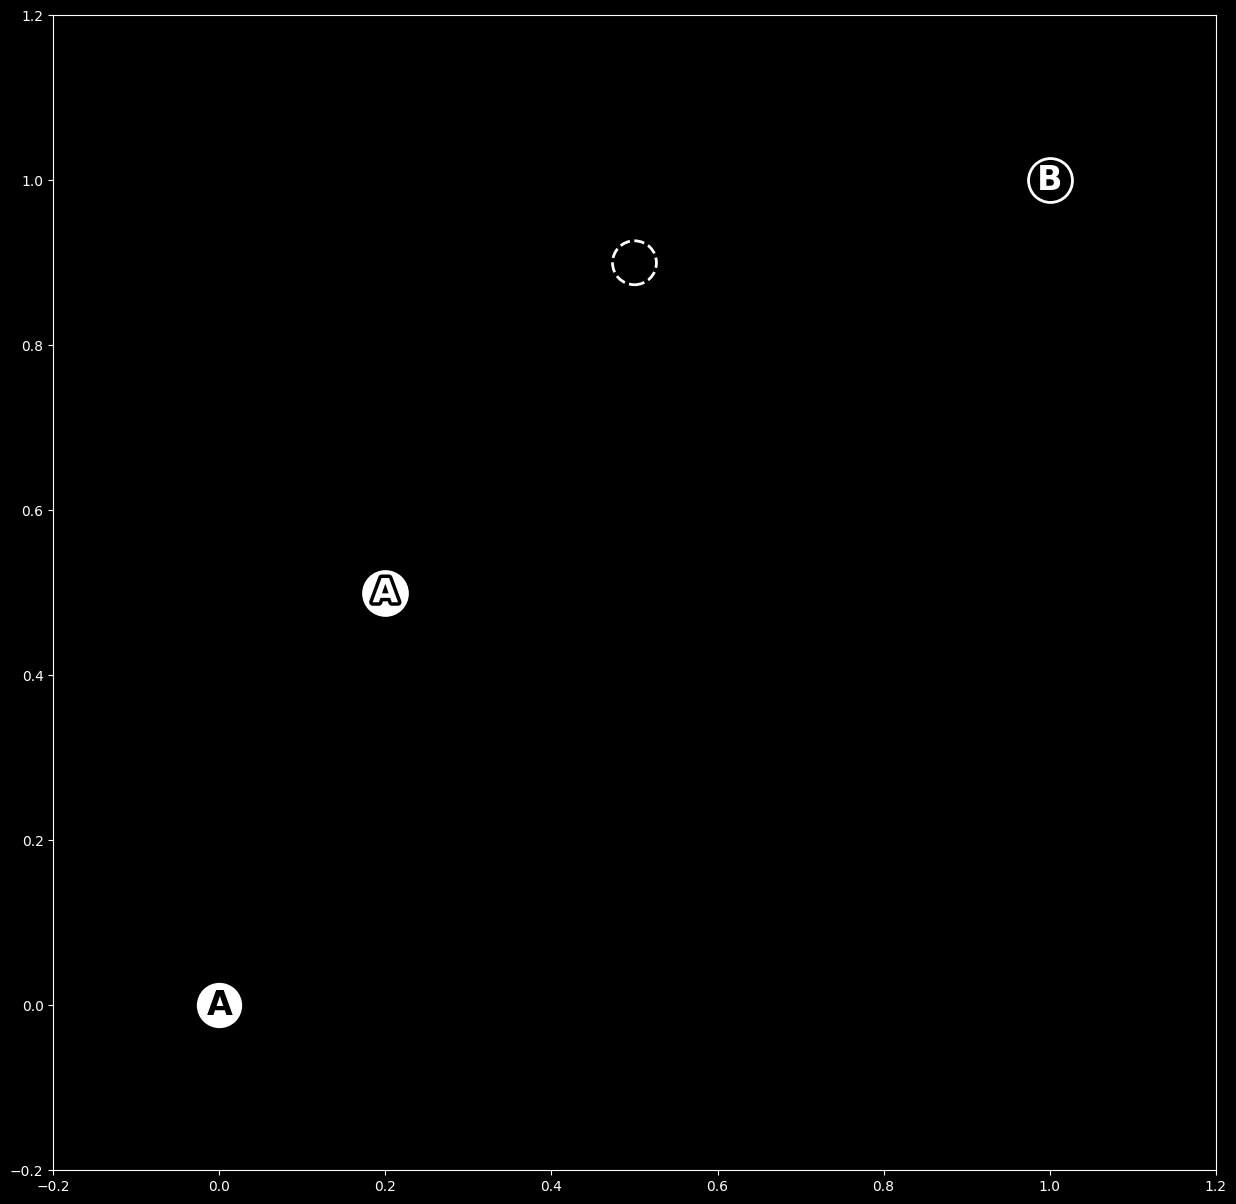

In [34]:
import matplotlib.patheffects as pe


plt.figure(figsize=(15,15))

plt.scatter(0,0,s=1000,c='w',marker='o')
plt.text(0,0,"A",c='k', ha='center', va='center',fontweight='bold', fontsize=24)


plt.scatter(1,1,s=1000,marker='o',edgecolor='w',facecolor='k', linewidths=2)
plt.text(1,1,"B",c='w', ha='center', va='center',fontweight='bold', fontsize=24)

plt.xlim(-.2, 1.2)
plt.ylim(-.2, 1.2)

(ax,ay), (bx,by) = (.5,.9), (.2,.5)

plt.scatter(ax, ay, s=1000, marker='o', edgecolor='w', facecolor='k', linewidth=2, linestyle='--')


plt.scatter(bx, by, s=1000, marker='o', edgecolor='w', facecolor='w', linewidth=2)
plt.text(bx, by,"A",color='w', ha='center', va='center',fontweight='bold', fontsize=24, path_effects=[pe.withStroke(linewidth=5, foreground="k")])
# plt.scatter(bx, by, s=1000, marker='o', edgecolor='k', facecolor='w', linewidth=2, linestyle='--')





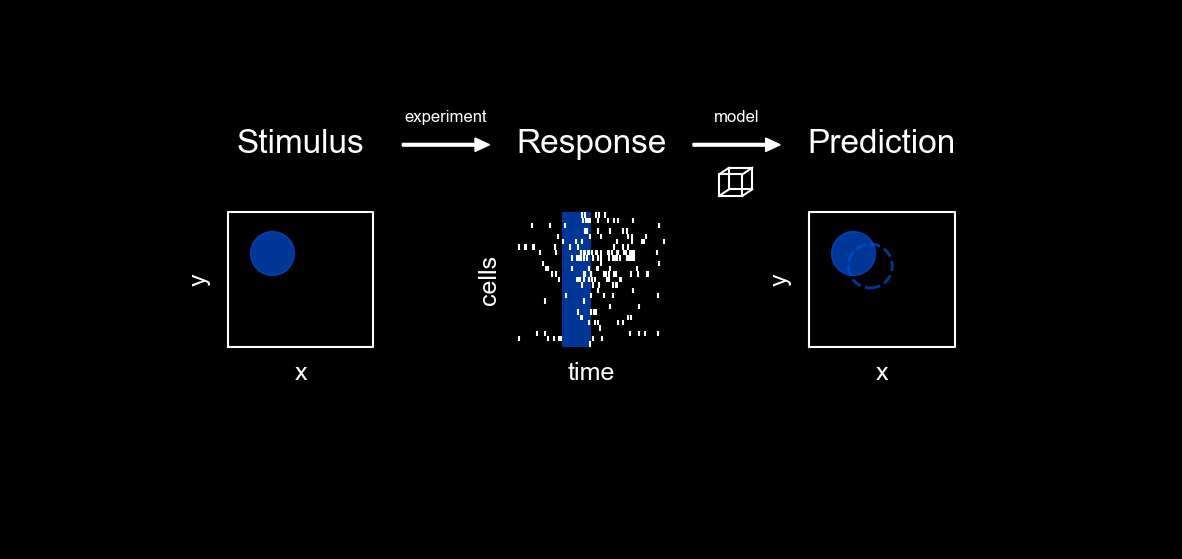

In [115]:
## Figure 3A

plt.figure(figsize=(15,7))
plt.xlim(-1,1)

plt.ylim(-1,1)

# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "Arial"
# })

font = 'Arial'
mstyle = {
    'font': font,
    'fontsize':24,
    'ha': 'center',
    'va': 'center'
}
sstyle = {
    'font': font,
    'fontsize':12,
    'ha': 'center',
    'va': 'center'
}

cstyle = {
    'font': font,
    'fontsize':18,
    'ha': 'center',
    'va': 'center'
}


plt.text(-.5, .5, 'Stimulus', **mstyle)
plt.text(0, .5, 'Response', **mstyle)
plt.text(.5, .5, 'Prediction', **mstyle)
# plt.text(0, -.4, 'Error', **mstyle)

plt.text(-.25, .6, 'experiment', **sstyle)
plt.text(.25, .6, 'model', **sstyle)

# fs = 'mathtt'
# plt.text(-.5, .7, f'$\\{fs}{{(x,y)}}$', **cstyle)
# plt.text(.5, .7, f'$\\{fs}{{(x,y)}}$', **cstyle)
# plt.text(0, .7, f'$\\{fs}{{[C {{\\times}} T]}}$', **cstyle)
# plt.text(0, -.6, f'$\\{fs}{{\\delta}}$', **cstyle)


f = .65
(ax,ay), (bx,by) = (-.5, .5), (0, .5)
plt.arrow(ax*f + bx*(1-f) , ay*f + by*(1-f), bx*(1-2*(1-f)) - ax*(1-2*(1-f)), by*(1-2*(1-f)) - ay*(1-2*(1-f)), width=.01, head_width=.05, head_length=.025, color='w', length_includes_head=True)

(ax,ay), (bx,by) = (0, .5), (.5, .5)
plt.arrow(ax*f + bx*(1-f) , ay*f + by*(1-f), bx*(1-2*(1-f)) - ax*(1-2*(1-f)), by*(1-2*(1-f)) - ay*(1-2*(1-f)), width=.01, head_width=.05, head_length=.025, color='w', length_includes_head=True)


# #error arrow...
# (ax,ay), (bx,by) = (0, .5), (.0, -.75)
# plt.arrow(ax*f + bx*(1-f) , ay*f + by*(1-f), bx*(1-2*(1-f)) - ax*(1-2*(1-f)), by*(1-2*(1-f)) - ay*(1-2*(1-f)), width=.005, head_width=.025, head_length=.05, color='w', length_includes_head=True)
# plt.plot([-.5, -.5, .5, .5], [.4, .07, .07, .4], c='w', linewidth = 3)


bx, by = .24, .35
bw, bh = .04, .08
bd = .07

x, y =  np.asarray([bx + bw/2, bx+bw/2, bx - bw/2, bx-bw/2, bx + bw/2]), np.asarray([by + bh/2, by-bh/2, by-bh/2, by + bh/2, by + bh/2,])
plt.plot(x, y, c='w')
plt.plot(x + bd*bx, y + bd*by, c='w')
for i in range(4):
    plt.plot([x[i], x[i] + bd*bx], [y[i], y[i] + bd*by], c='w')


bx,by = np.asarray([-1, 1, 1, -1, -1]), np.asarray([-1, -1, 1, 1, -1])
plt.plot(bx/8 - .5,by/4, c='w')
plt.scatter(-.55, .1, s=1000, c='#0052e2aa')
plt.plot(bx/8 + .5,by/4, c='w')
plt.scatter(.45, .1, s=1000, c='#0052e2aa')
# plt.scatter(.48, .05, s=1000, facecolor='none', edgecolor='k', linestyle='--', linewidth=3)
plt.scatter(.48, .05, s=1000, facecolor='none', edgecolor='#0052e2aa', linestyle='--', linewidth=2)

plt.fill_between([-.05,0], -.25, .25, facecolor='#0052e2aa', edgecolor='none')
for i in range(25):
    if np.random.rand() > .5: #on
        if np.random.rand() > .5: #responsive
            plt.vlines(np.random.rand(np.random.randint(10))*.1 -.025, -.25 + .02*i, -.23 + .02*i, color='w')
        else:
            plt.vlines(np.random.rand(np.random.randint(6))*.1 -.025, -.25 + .02*i, -.23 + .02*i, color='w')

        plt.vlines(np.random.rand(np.random.randint(3))*.25 - .125, -.25 + .02*i, -.23 + .02*i, color='w')

    else: #off
        if np.random.rand() > .5: #responsive
            plt.vlines(np.random.rand(np.random.randint(3))*.1 -.025, -.25 + .02*i, -.23 + .02*i, color='w')
        else:
            plt.vlines(np.random.rand(np.random.randint(23))*.1 -.025, -.25 + .02*i, -.23 + .02*i, color='w')

        plt.vlines(np.random.rand(np.random.randint(12))*.25 - .125, -.25 + .02*i, -.23 + .02*i, color='w')


plt.text(-.675, 0 , 'y', **cstyle, rotation=90)
plt.text(-.175, 0 , 'cells', **cstyle, rotation=90)
plt.text(.325, 0 , 'y', **cstyle, rotation=90)

plt.text(-.5, -.35 , 'x', **cstyle)
plt.text(0, -.35 , 'time', **cstyle)
plt.text(.5, -.35 , 'x', **cstyle)


# plt.axis('equal')

plt.axis('off')



plt.savefig(r"C:\Users\zfj\Downloads\Fig3A.svg", transparent=True)


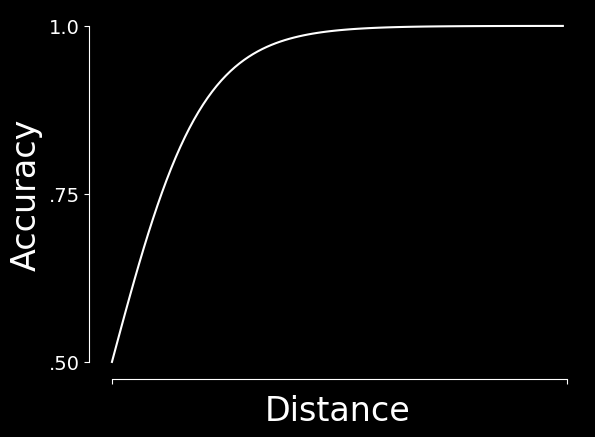

In [12]:
def logifunc(x,k):
        return 1. / (1 + np.exp(-k*x))

plt.plot(logifunc(np.linspace(0,10,100), 1.0), c='w')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines[['top','right']].set_color('none')
plt.gca().spines['left'].set_bounds([0.5,1.0])
plt.gca().spines['bottom'].set_bounds([0,100])

plt.yticks([0.5, 0.75, 1.0], labels=['.50', '.75', '1.0'])
plt.xticks([0, 100], labels=['', ''])

plt.ylabel('Accuracy', fontsize=24)
plt.xlabel('Distance', fontsize=24)


plt.savefig(r"C:\Users\zfj\Downloads\logistic.svg", transparent=True)

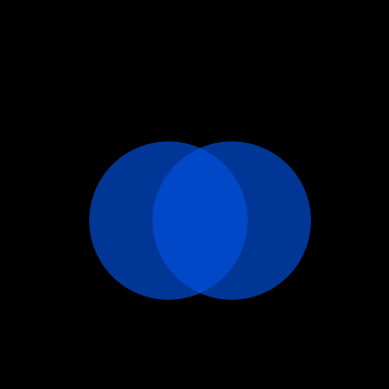

In [92]:
stimc='#0052e2aa'
from matplotlib.collections import EllipseCollection

# plt.scatter(0,0,s=10000,c=stimc)
# plt.scatter(1,0,s=10000,c=stimc)

plt.ylim(-.3, .4)
# plt.xlim([-.5, 1.5])
plt.xlim(-.3, .4)
plt.axis('off')
plt.axis('square')

sc = EllipseCollection(offsets = (0,0), widths = .3, heights = .3, angles=0, units='xy', offset_transform=plt.gca().transData, facecolors=stimc, edgecolors='none', linewidth=1)#, facecolors='None', edgecolors=sig)
plt.gca().add_collection(sc)

sc = EllipseCollection(offsets = (.06,0), widths = .3, heights = .3, angles=0, units='xy', offset_transform=plt.gca().transData, facecolors=stimc, edgecolors='none', linewidth=1)#, facecolors='None', edgecolors=sig)
plt.gca().add_collection(sc)



